<a href="https://colab.research.google.com/github/Alan240124/Alan/blob/main/Modelo_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Criando a Classe do Dataset

In [51]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("L")  # Converter para grayscale
        mask = Image.open(mask_path).convert("L")    # Converter para grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


Definindo a Transformação e o DataLoader

In [52]:
from torchvision import transforms

# Transforma as imagens para tensor e normaliza
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensione conforme necessário
    transforms.ToTensor(),
])

# Inicializa o dataset e o DataLoader
image_dir = "/content/drive/MyDrive/DataSet3/images"
mask_dir = "/content/drive/MyDrive/DataSet3/masks"
dataset = HeartDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


Implementação da U_net

In [53]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.conv_last(d1))

# Inicializar o modelo e definir o otimizador e a função de perda
model = UNet()
criterion = nn.BCELoss()  # Usamos BCELoss para segmentação binária
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Teste do Modelo

In [54]:
# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}")

    # Salva o modelo após cada epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")


Epoch [1/10], Loss: 0.7067637244860331
Epoch [2/10], Loss: 0.5753096838792165
Epoch [3/10], Loss: 0.45122374097506207
Epoch [4/10], Loss: 4.5115152100722
Epoch [5/10], Loss: 0.44256123900413513
Epoch [6/10], Loss: 0.46981547276179
Epoch [7/10], Loss: 0.41761576135953266
Epoch [8/10], Loss: 0.32663487394650775
Epoch [9/10], Loss: 0.21422896534204483
Epoch [10/10], Loss: 0.1773171772559484


Avaliação do Modelo

In [55]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Exemplo de uso com uma batch do DataLoader
model.eval()
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        dice = dice_coefficient(outputs, masks)
        print("DICE coefficient:", dice.item())
        break  # Apenas para uma batch


DICE coefficient: 0.6998487710952759


In [56]:
import torch

def dice_coefficient(pred, target, epsilon=1e-6):
    """Calcula o DICE Coefficient entre a predição e a máscara."""
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

def iou(pred, target, epsilon=1e-6):
    """Calcula o Intersection over Union (IoU) entre a predição e a máscara."""
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + epsilon) / (union + epsilon)

def precision(pred, target, epsilon=1e-6):
    """Calcula a precisão da segmentação."""
    true_positive = (pred * target).sum()
    predicted_positive = pred.sum()
    return (true_positive + epsilon) / (predicted_positive + epsilon)

def recall(pred, target, epsilon=1e-6):
    """Calcula o recall da segmentação."""
    true_positive = (pred * target).sum()
    actual_positive = target.sum()
    return (true_positive + epsilon) / (actual_positive + epsilon)

def accuracy(pred, target):
    """Calcula a acurácia da segmentação."""
    correct = (pred == target).float().sum()
    total = pred.numel()
    return correct / total


In [57]:
# Configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Função de avaliação
def evaluate_model(model, loader, threshold=0.5):
    model.eval()
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            # Predição
            outputs = model(images)
            outputs = (outputs > threshold).float()  # Binariza a predição

            # Calcula as métricas
            for i in range(images.size(0)):
                dice = dice_coefficient(outputs[i], masks[i])
                iou_score = iou(outputs[i], masks[i])
                prec = precision(outputs[i], masks[i])
                rec = recall(outputs[i], masks[i])
                acc = accuracy(outputs[i], masks[i])

                dice_scores.append(dice.item())
                iou_scores.append(iou_score.item())
                precision_scores.append(prec.item())
                recall_scores.append(rec.item())
                accuracy_scores.append(acc.item())

    # Calcula a média de cada métrica
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)

    print(f"DICE Coefficient: {mean_dice:.4f}")
    print(f"IoU Score: {mean_iou:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")
    print(f"Accuracy: {mean_accuracy:.4f}")

    return {
        "DICE": mean_dice,
        "IoU": mean_iou,
        "Precision": mean_precision,
        "Recall": mean_recall,
        "Accuracy": mean_accuracy
    }

# Avaliando o modelo no conjunto de validação
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)
evaluate_model(model, validation_loader)


DICE Coefficient: 0.7477
IoU Score: 0.6140
Precision: 0.6322
Recall: 0.9451
Accuracy: 0.7081


{'DICE': 0.7476766573058234,
 'IoU': 0.6139734437068304,
 'Precision': 0.6322429709964328,
 'Recall': 0.945103300942315,
 'Accuracy': 0.7080756293402778}

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inicializa o modelo, a função de perda e o otimizador
model = UNet().to(device)
criterion = nn.BCELoss()  # Como estamos usando segmentação binária, BCELoss é apropriado
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Parâmetros de treinamento
num_epochs = 10
best_dice = 0.0  # Para salvar o modelo com o melhor DICE Coefficient

# Função de treinamento do modelo
def train_model(model, train_loader, validation_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass e otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

        # Validação e cálculo das métricas
        validation_metrics = evaluate_model(model, validation_loader)
        mean_dice = validation_metrics["DICE"]
        print(f"Validation DICE Coefficient: {mean_dice:.4f}")

        # Salva o melhor modelo com base no DICE Coefficient
        global best_dice
        if mean_dice > best_dice:
            best_dice = mean_dice
            torch.save(model.state_dict(), "best_unet_model.pth")
            print("Melhor modelo salvo com DICE Coefficient:", best_dice)

# Carregar dados de treinamento e validação
# Certifique-se de que 'train_loader' e 'validation_loader' foram definidos
# Exemplo:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

# Executa o treinamento
train_model(model, train_loader, validation_loader, num_epochs=num_epochs)


100%|██████████| 3/3 [01:05<00:00, 21.79s/it]


Epoch [1/10], Loss: 0.7039
DICE Coefficient: 0.0000
IoU Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6408
Validation DICE Coefficient: 0.0000
Melhor modelo salvo com DICE Coefficient: 1.454557901594791e-10


100%|██████████| 3/3 [01:02<00:00, 20.88s/it]


Epoch [2/10], Loss: 0.6744
DICE Coefficient: 0.0000
IoU Score: 0.0000
Precision: 1.0000
Recall: 0.0000
Accuracy: 0.6409
Validation DICE Coefficient: 0.0000
Melhor modelo salvo com DICE Coefficient: 1.4572072252564775e-10


100%|██████████| 3/3 [01:02<00:00, 20.80s/it]


Epoch [3/10], Loss: 0.6122
DICE Coefficient: 0.4497
IoU Score: 0.3004
Precision: 0.9982
Recall: 0.3006
Accuracy: 0.6918
Validation DICE Coefficient: 0.4497
Melhor modelo salvo com DICE Coefficient: 0.449732255604532


100%|██████████| 3/3 [01:03<00:00, 21.25s/it]


Epoch [4/10], Loss: 0.5437
DICE Coefficient: 0.0021
IoU Score: 0.0010
Precision: 0.9996
Recall: 0.0010
Accuracy: 0.6411
Validation DICE Coefficient: 0.0021


100%|██████████| 3/3 [01:01<00:00, 20.63s/it]


Epoch [5/10], Loss: 0.4200
DICE Coefficient: 0.7800
IoU Score: 0.6477
Precision: 0.9808
Recall: 0.6564
Accuracy: 0.7337
Validation DICE Coefficient: 0.7800
Melhor modelo salvo com DICE Coefficient: 0.7800078656938341


100%|██████████| 3/3 [01:07<00:00, 22.43s/it]


Epoch [6/10], Loss: 0.2586
DICE Coefficient: 0.6195
IoU Score: 0.4579
Precision: 0.9959
Recall: 0.4589
Accuracy: 0.7124
Validation DICE Coefficient: 0.6195


100%|██████████| 3/3 [01:02<00:00, 20.86s/it]


Epoch [7/10], Loss: 0.2401
DICE Coefficient: 0.7287
IoU Score: 0.5829
Precision: 0.9886
Recall: 0.5871
Accuracy: 0.7271
Validation DICE Coefficient: 0.7287


100%|██████████| 3/3 [01:03<00:00, 21.08s/it]


Epoch [8/10], Loss: 0.1815
DICE Coefficient: 0.8204
IoU Score: 0.7107
Precision: 0.7637
Recall: 0.8978
Accuracy: 0.7338
Validation DICE Coefficient: 0.8204
Melhor modelo salvo com DICE Coefficient: 0.820418182346556


100%|██████████| 3/3 [01:02<00:00, 20.81s/it]


Epoch [9/10], Loss: 0.1429
DICE Coefficient: 0.8219
IoU Score: 0.7129
Precision: 0.7627
Recall: 0.9031
Accuracy: 0.7339
Validation DICE Coefficient: 0.8219
Melhor modelo salvo com DICE Coefficient: 0.8219465911388397


100%|██████████| 3/3 [01:01<00:00, 20.64s/it]


Epoch [10/10], Loss: 0.1362
DICE Coefficient: 0.8520
IoU Score: 0.7484
Precision: 0.9416
Recall: 0.7844
Accuracy: 0.7431
Validation DICE Coefficient: 0.8520
Melhor modelo salvo com DICE Coefficient: 0.852028316921658


In [59]:
import torch

# Carregar o modelo salvo
model = UNet().to(device)
model.load_state_dict(torch.load("best_unet_model.pth"))
model.eval()  # Coloca o modelo em modo de avaliação


<ipython-input-59-101619d8c989>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_unet_model.pth"))


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder4): Sequenti

In [62]:
# Carregar o conjunto de teste
test_image_dir = "/content/drive/MyDrive/DataSet3/images"
test_mask_dir = "/content/drive/MyDrive/DataSet3/masks"
test_dataset = HeartDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)


In [63]:
def test_model(model, loader, threshold=0.5):
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            # Predição
            outputs = model(images)
            outputs = (outputs > threshold).float()  # Binariza a predição

            # Calcula as métricas
            for i in range(images.size(0)):
                dice = dice_coefficient(outputs[i], masks[i])
                iou_score = iou(outputs[i], masks[i])
                prec = precision(outputs[i], masks[i])
                rec = recall(outputs[i], masks[i])
                acc = accuracy(outputs[i], masks[i])

                dice_scores.append(dice.item())
                iou_scores.append(iou_score.item())
                precision_scores.append(prec.item())
                recall_scores.append(rec.item())
                accuracy_scores.append(acc.item())

    # Calcula a média de cada métrica
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)

    print(f"Test DICE Coefficient: {mean_dice:.4f}")
    print(f"Test IoU Score: {mean_iou:.4f}")
    print(f"Test Precision: {mean_precision:.4f}")
    print(f"Test Recall: {mean_recall:.4f}")
    print(f"Test Accuracy: {mean_accuracy:.4f}")

    return {
        "DICE": mean_dice,
        "IoU": mean_iou,
        "Precision": mean_precision,
        "Recall": mean_recall,
        "Accuracy": mean_accuracy
    }

# Executa a função de teste
test_results = test_model(model, test_loader)


Test DICE Coefficient: 0.8520
Test IoU Score: 0.7484
Test Precision: 0.9416
Test Recall: 0.7844
Test Accuracy: 0.7431


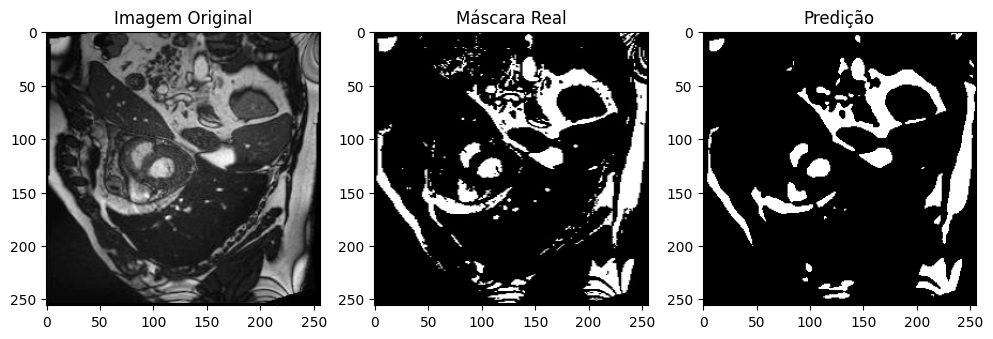

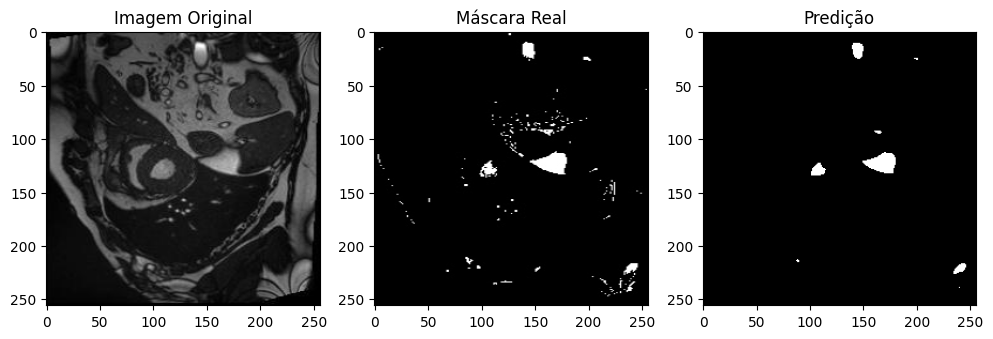

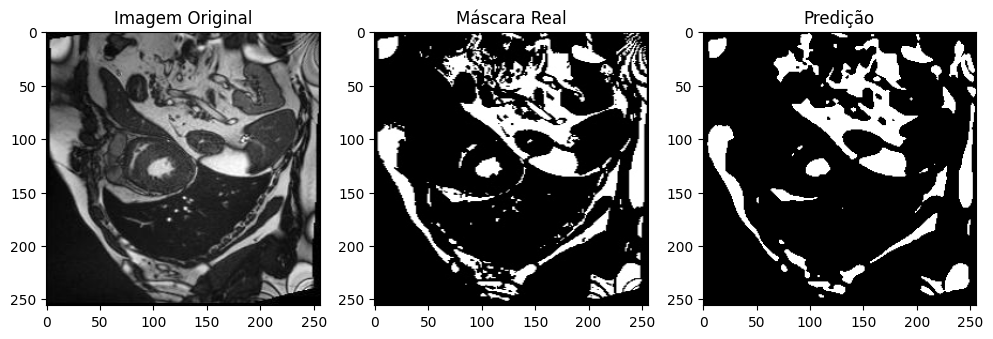

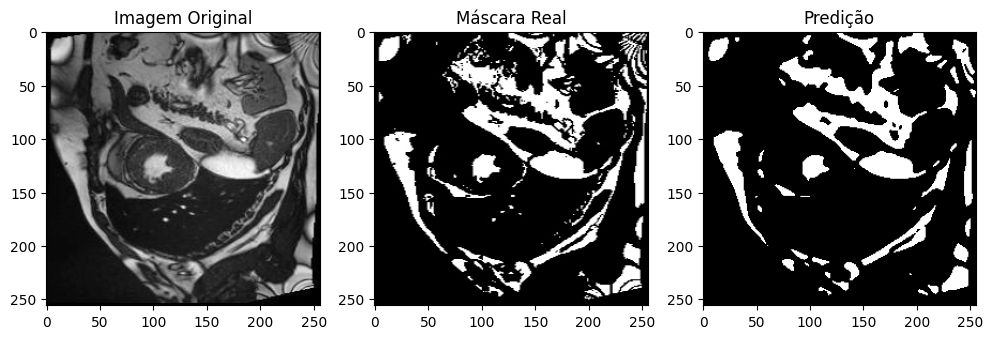

In [64]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_images=4):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Binarizar a saída

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(images[i].cpu().squeeze(), cmap='gray')
                ax[0].set_title("Imagem Original")
                ax[1].imshow(masks[i].cpu().squeeze(), cmap='gray')
                ax[1].set_title("Máscara Real")
                ax[2].imshow(outputs[i].cpu().squeeze(), cmap='gray')
                ax[2].set_title("Predição")
                plt.show()
                images_shown += 1

# Visualiza algumas predições no conjunto de teste
visualize_predictions(model, test_loader)


In [65]:
class HeartDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [66]:
train_dataset = HeartDataset(images=train_images, masks=train_masks, transform=transform)
val_dataset = HeartDataset(images=val_images, masks=val_masks, transform=transform)
test_dataset = HeartDataset(images=test_images, masks=test_masks, transform=transform)


In [67]:
import os

# Definindo os caminhos das pastas de imagens e máscaras
image_dir = "/content/drive/MyDrive/DataSet3/images"
mask_dir = "/content/drive/MyDrive/DataSet3/masks"

# Listando todos os arquivos nas pastas de imagens e máscaras
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(".jpg")]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir) if filename.endswith(".jpg")]

# Exibindo os primeiros caminhos para verificar
print("Caminhos das imagens:", image_paths[:5])
print("Caminhos das máscaras:", mask_paths[:5])


Caminhos das imagens: ['/content/drive/MyDrive/DataSet3/images/image.0006.jpg', '/content/drive/MyDrive/DataSet3/images/image.0007.jpg', '/content/drive/MyDrive/DataSet3/images/image.0003.jpg', '/content/drive/MyDrive/DataSet3/images/image.0008.jpg', '/content/drive/MyDrive/DataSet3/images/image.0005.jpg']
Caminhos das máscaras: ['/content/drive/MyDrive/DataSet3/masks/image.0009.jpg', '/content/drive/MyDrive/DataSet3/masks/image.0005.jpg', '/content/drive/MyDrive/DataSet3/masks/image.0002.jpg', '/content/drive/MyDrive/DataSet3/masks/image.0006.jpg', '/content/drive/MyDrive/DataSet3/masks/image.0008.jpg']


In [68]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(128, 108)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size  # Tamanho de saída desejado para as máscaras
        self.images = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])
        self.masks = sorted([f for f in os.listdir(root_dir.replace('images', 'masks')) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.root_dir.replace('images', 'masks'), self.masks[idx])

        image = Image.open(img_name).convert("L")  # Converter para escala de cinza
        mask = Image.open(mask_name).convert("L")  # Converter para escala de cinza

        # Redimensionar a máscara para o mesmo tamanho da imagem de entrada
        mask = mask.resize(self.target_size, Image.BILINEAR)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Definindo os DataLoaders para treino e validação com a transformação
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/DataSet3/images', transform=transform)
val_dataset = CustomDataset(root_dir='/content/drive/MyDrive/DataSet3/masks', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [69]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class HeartDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """
        Construtor da classe que recebe os caminhos das imagens e das máscaras.

        Args:
        - image_paths (list): Lista de caminhos para as imagens.
        - mask_paths (list): Lista de caminhos para as máscaras.
        - transform (callable, optional): Transformações a serem aplicadas nas imagens e máscaras.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        """
        Retorna o número de elementos no dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retorna uma imagem e sua máscara correspondente.

        Args:
        - idx (int): Índice do item no dataset.

        Returns:
        - dict: Um dicionário com a imagem e a máscara (e transformações, se houver).
        """
        # Carregar a imagem e a máscara
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Abre a imagem
        mask = Image.open(self.mask_paths[idx]).convert('L')    # Abre a máscara (em escala de cinza)

        # Aplicar as transformações, se fornecidas
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {'image': image, 'mask': mask}


In [70]:
import torch
import torch.nn as nn

# Implementação simplificada do modelo U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Definir as camadas de convolução (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Camadas de convolução (upsampling)
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Para a segmentação binária
        )

    def forward(self, x):
        # Passagem pelo encoder
        x = self.encoder(x)
        # Passagem pelo decoder
        x = self.decoder(x)
        return x

# Criando o modelo e verificando se tem parâmetros
model = UNet()
print("Parâmetros do modelo:")
for param in model.parameters():
    print(param.shape)

# Configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover o modelo para o dispositivo
model = model.to(device)

# Inicializar a função de perda e o otimizador
criterion = nn.BCELoss()  # Para segmentação binária
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Verificar se os parâmetros foram definidos corretamente
print(f"Parâmetros do modelo: {len(list(model.parameters()))}")


Parâmetros do modelo:
torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([1, 64, 3, 3])
torch.Size([1])
Parâmetros do modelo: 8


In [71]:
import torch.nn.functional as F

# Função de redimensionamento
def resize_to_match(pred, target):
    # Ajusta o tamanho de pred para o tamanho de target
    return F.interpolate(pred, size=target.shape[2:], mode='bilinear', align_corners=False)

# Função para testar o modelo
def test_model(model, test_loader, threshold=0.5):
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    model.eval()
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Predição
            outputs = model(images)
            outputs = (outputs > threshold).float()  # Binariza a saída

            # Ajuste de tamanho da saída para coincidir com o tamanho das máscaras
            outputs = resize_to_match(outputs, masks)

            # Calcula as métricas
            for i in range(images.size(0)):
                dice = dice_coefficient(outputs[i], masks[i])
                iou_score = iou(outputs[i], masks[i])
                prec = precision(outputs[i], masks[i])
                rec = recall(outputs[i], masks[i])
                acc = accuracy(outputs[i], masks[i])

                dice_scores.append(dice.item())
                iou_scores.append(iou_score.item())
                precision_scores.append(prec.item())
                recall_scores.append(rec.item())
                accuracy_scores.append(acc.item())

    # Calcula a média de cada métrica
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)

    print(f"Test DICE Coefficient: {mean_dice:.4f}")
    print(f"Test IoU Score: {mean_iou:.4f}")
    print(f"Test Precision: {mean_precision:.4f}")
    print(f"Test Recall: {mean_recall:.4f}")
    print(f"Test Accuracy: {mean_accuracy:.4f}")

    return {
        "DICE": mean_dice,
        "IoU": mean_iou,
        "Precision": mean_precision,
        "Recall": mean_recall,
        "Accuracy": mean_accuracy
    }

# Executa a função de teste
test_results = test_model(model, test_loader)


Test DICE Coefficient: 0.3323
Test IoU Score: 0.2050
Test Precision: 0.2050
Test Recall: 1.0000
Test Accuracy: 0.1129


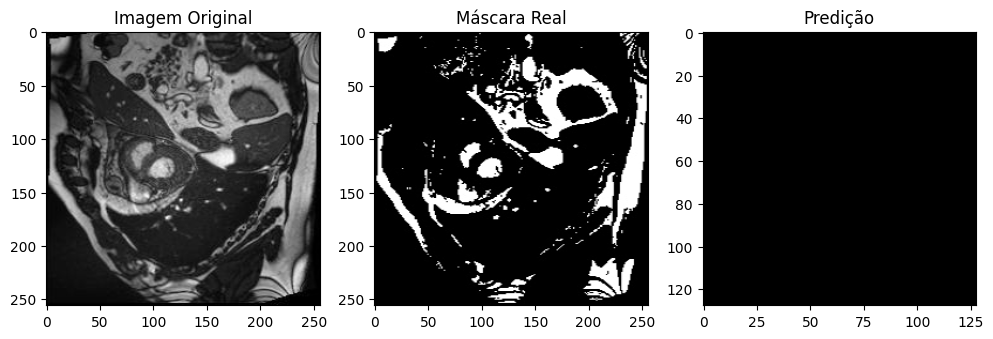

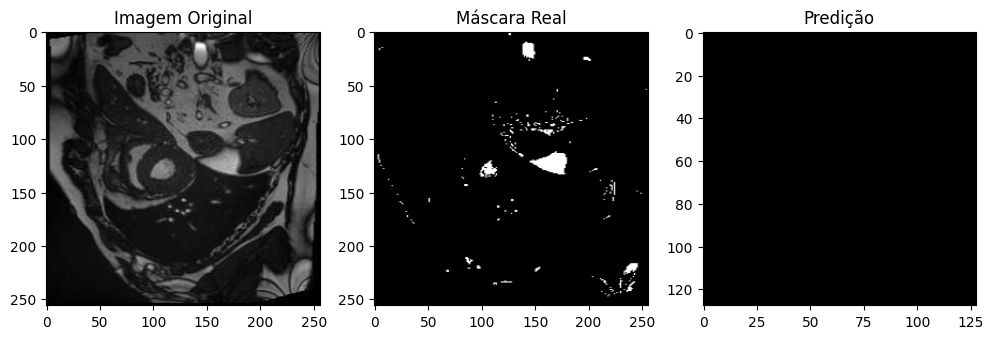

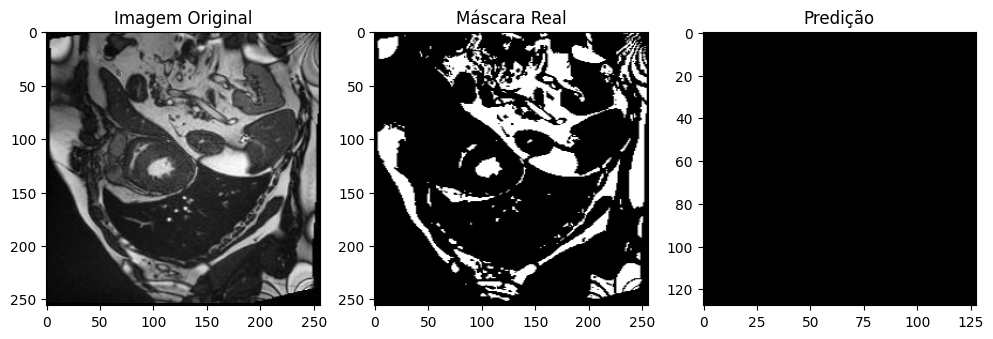

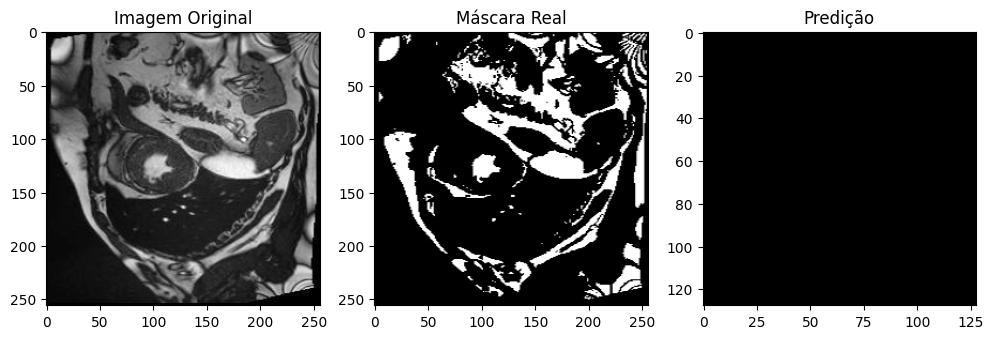

In [73]:
import matplotlib.pyplot as plt

# Função para visualizar previsões
def visualize_predictions(model, loader, num_images=4):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Binariza a saída

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(images[i].cpu().squeeze(), cmap='gray')
                ax[0].set_title("Imagem Original")
                ax[1].imshow(masks[i].cpu().squeeze(), cmap='gray')
                ax[1].set_title("Máscara Real")
                ax[2].imshow(outputs[i].cpu().squeeze(), cmap='gray')
                ax[2].set_title("Predição")
                plt.show()
                images_shown += 1

# Visualiza algumas previsões no conjunto de teste
visualize_predictions(model, test_loader)
